In [1]:
import os, sys, argparse
%matplotlib inline 
from matplotlib import pyplot
import numpy as np

possible_callers = ('mutect', 'muse', 'somaticsniper', 'varscan')
possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
                    'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO',
                    'OV','PAAD','PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')

# functions
def parse_maf(fp):
	''' Return a dictionary with vars[patient][variant_set]'''
	caller_vars = {}

	fh = open(fp, 'r')
	for line in fh:
		temp = line.strip().split('\t')
		if line[0] == '#' or temp[0] == 'Hugo_Symbol':
			continue
		ID = temp[16] + '_' + temp[17] # 'tumor'_'normal'
		if ID not in caller_vars:
			caller_vars[ID] = set()
		chrom =temp[4]
		s_pos = temp[5]
		e_pos = temp[6]
		ref = temp[11]
		tum_allele_1 = temp[12]
		tum_allele_2 = temp[13]
		var = (chrom, s_pos, e_pos, ref, tum_allele_1, tum_allele_2)
		caller_vars[ID].add(var)

	return(caller_vars)



In [2]:
def four_set_fractions(dat_1, dat_2, dat_3, dat_4):
    dat = []
    
    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) & set(list(dat_4.keys()))

    for patient in patients:
        top = []
        fractions = []
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        set_4 = dat_4[patient]
        
        total = len(set_1 | set_2 | set_3 | set_4)
    
        inter = len(set_1 & set_2 & set_3 & set_4)
        top.append(inter)
        inter_123 = len(set_1 & set_2 & set_3) - inter
        top.append(inter_123)
        inter_124 = len(set_1 & set_2 & set_4) - inter
        top.append(inter_124)
        inter_134 = len(set_1 & set_3 & set_4) - inter
        top.append(inter_134)
        inter_234 = len(set_2 & set_3 & set_4) - inter
        top.append(inter_234)
        
        
        inter_12 = len(set_1 & set_2) - inter - inter_123 - inter_124
        top.append(inter_12)
        inter_13 = len(set_1 & set_3) - inter - inter_123 - inter_134
        top.append(inter_13)
        inter_14 = len(set_1 & set_4) - inter - inter_124 - inter_134
        top.append(inter_14)
        inter_23 = len(set_2 & set_3) - inter - inter_123 - inter_234
        top.append(inter_23)
        inter_24 = len(set_2 & set_4) - inter - inter_124 - inter_234
        top.append(inter_24)
        inter_34 = len(set_3 & set_4) - inter - inter_234 - inter_134
        top.append(inter_34)
        
        diff_1 = len(set_1) - inter - inter_13 - inter_12 - inter_14 - inter_123 - inter_134 - inter_124
        top.append(diff_1)
        diff_2 = len(set_2) - inter - inter_12 - inter_23 - inter_24 - inter_123 - inter_124 - inter_234
        top.append(diff_2)
        diff_3 = len(set_3) - inter - inter_13 - inter_23 - inter_34 - inter_123 - inter_134 - inter_234
        top.append(diff_3)
        diff_4 = len(set_4) - inter - inter_14 - inter_24 - inter_34 - inter_124 - inter_134 - inter_234
        top.append(diff_4)
        for t in top:
            fractions.append(t/total)
        dat.append(fractions)
    
    return dat


In [3]:
import matplotlib.pyplot as plt
from itertools import combinations
from simple_venn import venn2, venn3, venn4

original = os.getcwd()

interallvar = []
interallmean = []

inter123allvar = []
inter124allvar = []
inter134allvar = []
inter234allvar = []
    
inter123allmean = []
inter124allmean = []
inter134allmean = []
inter234allmean = []


inter12allvar = []
inter13allvar = []
inter14allvar = []
inter23allvar = []
inter24allvar = []
inter34allvar = []
    
inter12allmean = []
inter13allmean = []
inter14allmean = []
inter23allmean = []
inter24allmean = []
inter34allmean = []

diff1allvar = []
diff2allvar = []
diff3allvar = []
diff4allvar = []
    
diff1allmean = []
diff2allmean = []
diff3allmean = []
diff4allmean = []
    
for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
    all_variants = {}
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    num_callers = len(possible_callers)
    
    dat = four_set_fractions(all_variants[possible_callers[0]], all_variants[possible_callers[1]], all_variants[possible_callers[2]], all_variants[possible_callers[3]])
    #print(dat)
    
    interall = []

    inter123all = []
    inter124all = []
    inter134all = []
    inter234all = []
    
    
    inter12all = []
    inter13all = []
    inter14all = []
    inter23all = []
    inter24all = []
    inter34all = []
    
    
    
    diff1all = []
    diff2all = []
    diff3all = []
    diff4all = []
    
    for d in dat:
        interall.append(d[0])
        inter123all.append(d[1])
        inter124all.append(d[2])
        inter134all.append(d[3])
        inter234all.append(d[4])
        inter12all.append(d[5])
        inter13all.append(d[6])
        inter14all.append(d[7])
        inter23all.append(d[8])
        inter24all.append(d[9])
        inter34all.append(d[10])
        diff1all.append(d[11])
        diff2all.append(d[12])
        diff3all.append(d[13])
        diff4all.append(d[14])
        
    print(cancer)    
    print("all:", np.mean(interall), np.var(interall))
    interallmean.append(np.mean(interall))
    interallvar.append(np.var(interall))
    
    print("mutect:", np.mean(diff1all), np.var(diff1all))
    diff1allmean.append(np.mean(diff1all))
    diff1allvar.append(np.var(diff1all))
    
    print("muse:", np.mean(diff2all), np.var(diff2all))
    diff2allmean.append(np.mean(diff2all))
    diff2allvar.append(np.var(diff2all))
    
    print("somaticsniper:", np.mean(diff3all), np.var(diff3all))
    diff3allmean.append(np.mean(diff3all))
    diff3allvar.append(np.var(diff3all))
    
    print("varscan:", np.mean(diff4all), np.var(diff4all))
    diff4allmean.append(np.mean(diff4all))
    diff4allvar.append(np.var(diff4all))
    
    print("mutect+muse:", np.mean(inter12all), np.var(inter12all))
    inter12allmean.append(np.mean(inter12all))
    inter12allvar.append(np.var(inter12all))
    
    print("mutect+somaticsniper:", np.mean(inter13all), np.var(inter13all))
    inter13allmean.append(np.mean(inter13all))
    inter13allvar.append(np.var(inter13all))
    
    print("mutect+varscan:", np.mean(inter14all), np.var(inter14all))
    inter14allmean.append(np.mean(inter14all))
    inter14allvar.append(np.var(inter14all))
    
    print("muse+somaticsniper:", np.mean(inter23all), np.var(inter23all))
    inter23allmean.append(np.mean(inter23all))
    inter23allvar.append(np.var(inter23all))
    
    print("muse+varscan:", np.mean(inter24all), np.var(inter24all))
    inter24allmean.append(np.mean(inter24all))
    inter24allvar.append(np.var(inter24all))
    
    print("somaticsniper+varscan:", np.mean(inter34all), np.var(inter34all))
    inter34allmean.append(np.mean(inter34all))
    inter34allvar.append(np.var(inter34all))
    
    print("mutect+muse+somaticsniper:", np.mean(inter123all), np.var(inter123all))
    inter123allmean.append(np.mean(inter123all))
    inter123allvar.append(np.var(inter123all))
    
    print("mutect+muse+varscan:", np.mean(inter124all), np.var(inter124all))
    inter124allmean.append(np.mean(inter124all))
    inter124allvar.append(np.var(inter124all))
    
    print("mutect+somaticsniper+varscan:", np.mean(inter134all), np.var(inter134all))
    inter134allmean.append(np.mean(inter134all))
    inter134allvar.append(np.var(inter134all))
    
    print("muse+somaticsniper+varscan:", np.mean(inter234all), np.var(inter234all))
    inter234allmean.append(np.mean(inter234all))
    inter234allvar.append(np.var(inter234all))


ACC
all: 0.4422030271453525 0.020103125595957724
mutect: 0.15215935419117504 0.009343582328017451
muse: 0.018870084596991712 0.0006684433840377187
somaticsniper: 0.015852156083001053 0.0004429922470596442
varscan: 0.07829564677324789 0.004278567738936815
mutect+muse: 0.04919218662355881 0.0016067311481563248
mutect+somaticsniper: 0.008209234226313214 0.0002160262931736918
mutect+varscan: 0.05623718531720941 0.001665452627311563
muse+somaticsniper: 0.0037594953013593605 8.72239204409889e-05
muse+varscan: 0.009002336766068481 0.00024294625328533584
somaticsniper+varscan: 0.04090495005867129 0.0018583165727107747
mutect+muse+somaticsniper: 0.028510370366774052 0.0017009043639196427
mutect+muse+varscan: 0.05494860649078925 0.003439425385462913
mutect+somaticsniper+varscan: 0.012371257859016882 0.000296123368673036
muse+somaticsniper+varscan: 0.02948410820047102 0.0007985682853055373
BLCA
all: 0.5209545593017414 0.029369680364690787
mutect: 0.1246609241565346 0.014626926753167237
muse: 0.02

KICH
all: 0.3424918403691233 0.015682707756292522
mutect: 0.24134446964478556 0.013002358093047643
muse: 0.015428125015013608 0.0006673745799174737
somaticsniper: 0.02102467535686557 0.001054167383035753
varscan: 0.11830098879744609 0.0029114810646620336
mutect+muse: 0.03335242420261221 0.0010120611350887658
mutect+somaticsniper: 0.0066255581805999405 0.00022338081704830837
mutect+varscan: 0.06800726744221192 0.0022475415061655635
muse+somaticsniper: 0.001990216424815795 6.77131732791577e-05
muse+varscan: 0.010858383128129102 0.0003147138780662218
somaticsniper+varscan: 0.02235613120572772 0.0012829179373628856
mutect+muse+somaticsniper: 0.02199664692571614 0.0005926340647601357
mutect+muse+varscan: 0.05829006848003349 0.0027520986986661403
mutect+somaticsniper+varscan: 0.013303938983190516 0.0004469441594787396
muse+somaticsniper+varscan: 0.02462926584372903 0.0009629048488466087
KIRC
all: 0.45727077534438787 0.028331995410777917
mutect: 0.12927898243527447 0.00983135433702689
muse: 0

PAAD
all: 0.329900498833839 0.05790338973295336
mutect: 0.18876538181224226 0.025731601881682345
muse: 0.024897494946456718 0.0006409697181531047
somaticsniper: 0.004160748546426372 8.890276904025389e-05
varscan: 0.01742227098575209 0.0004806986796283656
mutect+muse: 0.1446160605788817 0.0158207462316288
mutect+somaticsniper: 0.0020587423144469955 5.1361393968528914e-05
mutect+varscan: 0.04267371351692334 0.001154642007378518
muse+somaticsniper: 0.0017989971302440533 2.6462807743408498e-05
muse+varscan: 0.009671439159784464 0.00017359724204904145
somaticsniper+varscan: 0.004652471019332025 0.00016113545792722302
mutect+muse+somaticsniper: 0.010258786774311131 0.0018051250389292167
mutect+muse+varscan: 0.20557562147425085 0.025937784781501803
mutect+somaticsniper+varscan: 0.002407702163363074 4.284699847471303e-05
muse+somaticsniper+varscan: 0.011140070743745881 0.00024535781820258606
PCPG
all: 0.4366905244227243 0.029801915970751096
mutect: 0.2605207572632593 0.02115017261588194
muse: 

UCEC
all: 0.5065676363629786 0.024084484229858153
mutect: 0.1464561049085078 0.023719893012343837
muse: 0.01698033153444969 0.00023096400992414138
somaticsniper: 0.0068054729417299795 0.00011187173423771872
varscan: 0.06504638715443203 0.002864276218941008
mutect+muse: 0.04148344766388123 0.0006216282204768121
mutect+somaticsniper: 0.007068189426094407 0.00013598363791805448
mutect+varscan: 0.09431540297440985 0.0047900386048982295
muse+somaticsniper: 0.0012955804842475559 1.016206942687087e-05
muse+varscan: 0.007744589190233907 0.00012134506502797995
somaticsniper+varscan: 0.009095690163190723 0.00011979848973670958
mutect+muse+somaticsniper: 0.009465956495821621 0.000259125140285703
mutect+muse+varscan: 0.04777921476555823 0.002757003684199741
mutect+somaticsniper+varscan: 0.01878133821181332 0.0003166205279707366
muse+somaticsniper+varscan: 0.02111465772265092 0.00044199498424528523
UCS
all: 0.5203082890341792 0.012740188144080133
mutect: 0.1066762263830333 0.002538969744634697
muse

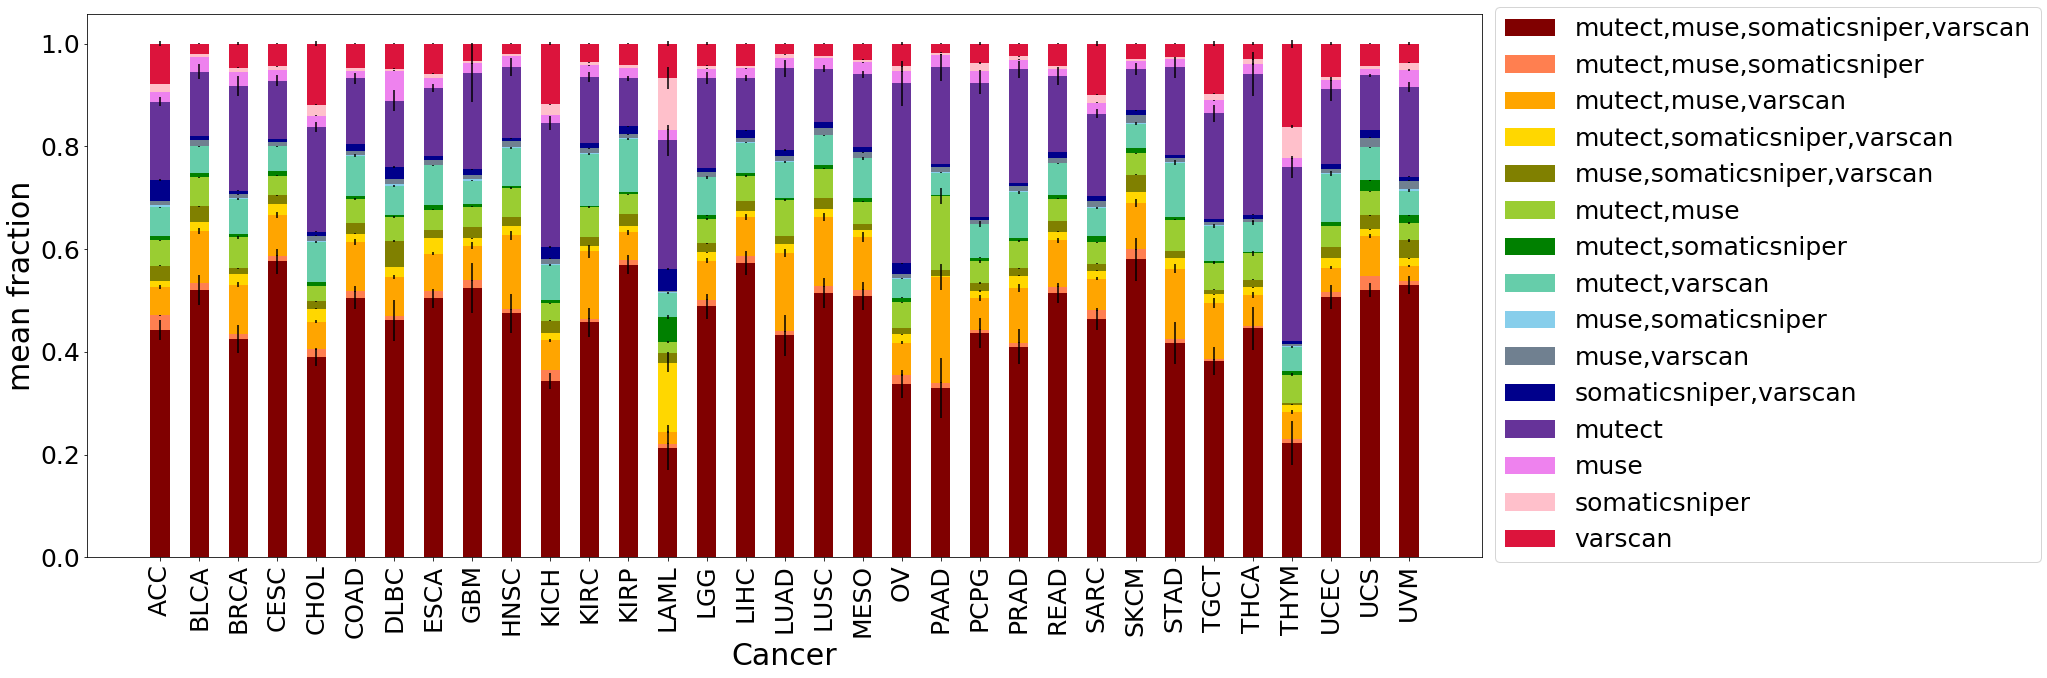

In [7]:
os.chdir(original)
interallmean = np.array(interallmean)
inter123allmean = np.array(inter123allmean)
inter124allmean = np.array(inter124allmean)
inter134allmean = np.array(inter134allmean)
inter234allmean = np.array(inter234allmean)
inter12allmean = np.array(inter12allmean)
inter13allmean = np.array(inter13allmean)
inter14allmean = np.array(inter14allmean)
inter23allmean = np.array(inter23allmean)
inter24allmean = np.array(inter24allmean)
inter34allmean = np.array(inter34allmean)
diff1allmean = np.array(diff1allmean)
diff2allmean = np.array(diff2allmean)
diff3allmean = np.array(diff3allmean)
diff4allmean = np.array(diff4allmean)

ind = np.arange(33)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
#print(interallmean)
plt.figure(figsize=(25,10))
p1 = plt.bar(ind, interallmean, width, yerr=interallvar, label = 'mutect,muse,somaticsniper,varscan', color = 'maroon')
p2 = plt.bar(ind, inter123allmean, width, bottom=interallmean, label = 'mutect,muse,somaticsniper', yerr=inter123allvar, color = 'coral')
p3 = plt.bar(ind, inter124allmean, width, bottom = inter123allmean+interallmean, label = 'mutect,muse,varscan', yerr=inter124allvar, color = 'orange')
p4 = plt.bar(ind, inter134allmean, width, bottom = inter124allmean+inter123allmean+interallmean, label = 'mutect,somaticsniper,varscan', yerr=inter134allvar, color = 'gold')
p5 = plt.bar(ind, inter234allmean, width, bottom = inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'muse,somaticsniper,varscan', yerr=inter234allvar, color = 'olive')
p6 = plt.bar(ind, inter12allmean, width, bottom=inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'mutect,muse', yerr=inter12allvar, color = 'yellowgreen')
p7 = plt.bar(ind, inter13allmean, width, bottom=inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'mutect,somaticsniper', yerr=inter13allvar, color = 'g')
p8 = plt.bar(ind, inter14allmean, width, bottom=inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'mutect,varscan', yerr=inter14allvar, color = 'mediumaquamarine')
p9 = plt.bar(ind, inter23allmean, width, bottom=inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'muse,somaticsniper', yerr=inter23allvar, color = 'skyblue')
p10 = plt.bar(ind, inter24allmean, width, bottom=inter23allmean+inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'muse,varscan', yerr=inter24allvar, color = 'slategrey')
p11 = plt.bar(ind, inter34allmean, width, bottom=inter24allmean+inter23allmean+inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'somaticsniper,varscan', yerr=inter34allvar, color = 'darkblue')
p12 = plt.bar(ind, diff1allmean, width, bottom=inter34allmean+inter24allmean+inter23allmean+inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'mutect', yerr=diff1allvar, color = 'rebeccapurple')
p13 = plt.bar(ind, diff2allmean, width, bottom=diff1allmean+inter34allmean+inter24allmean+inter23allmean+inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'muse', yerr=diff2allvar, color = 'violet')
p14 = plt.bar(ind, diff3allmean, width, bottom=diff2allmean+diff1allmean+inter34allmean+inter24allmean+inter23allmean+inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'somaticsniper', yerr=diff3allvar, color = 'pink')
p15 = plt.bar(ind, diff4allmean, width, bottom=diff3allmean+diff2allmean+diff1allmean+inter34allmean+inter24allmean+inter23allmean+inter14allmean+inter13allmean+inter12allmean+inter234allmean+inter134allmean+inter124allmean+inter123allmean+interallmean, label = 'varscan', yerr=diff4allvar, color = 'crimson')

#print(interallvar)
plt.xticks(np.arange(33), possible_cancers, rotation=90)
plt.legend(fontsize = 'small', bbox_to_anchor=(1.0, 1.035))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.rcParams.update({'font.size': 30})
plt.xlabel('Cancer')
plt.ylabel('mean fraction')
filename = ("gdcstats.pdf")
pyplot.savefig(filename)
plt.show()